### 07-Yelp-Cluster.ipynb
* **Script**: 07-Yelp-Cluser.ipynb
* **Purpose**: Explore ways to cluster Yelp users by topics most often discussed in their reviews
* **Input**: data/yelp/dataframes/yelp_review_user.pkl
* **Output**: Various Statistics (embedded in this notebook)

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, DBSCAN

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
#Function to Print Percentiles (for Cleaning)
def percentiles(df, variable):
    print "Min:  "+str(df[variable].quantile(q=0.00))
    print "1st:  "+str(df[variable].quantile(q=0.01))
    print "5th:  "+str(df[variable].quantile(q=0.05))
    print "10th: "+str(df[variable].quantile(q=0.10))
    print "25th: "+str(df[variable].quantile(q=0.25))
    print "50th: "+str(df[variable].quantile(q=0.50))
    print "75th: "+str(df[variable].quantile(q=0.75))
    print "90th: "+str(df[variable].quantile(q=0.90))
    print "95th: "+str(df[variable].quantile(q=0.95))
    print "99th: "+str(df[variable].quantile(q=0.99))
    print "Max:  "+str(df[variable].quantile(q=1.00))

In [3]:
user = pd.read_pickle("data/yelp/dataframes/yelp_review_user.pkl")
user.head(5)

,user_id,topic_food,topic_service,topic_ambience,topic_value,relevant,total
0,--9jRaeY1xK-2l9r9fVQWA,31,8,13,5,46,90
1,--ECBYLVpIfQaeX_35i63Q,48,14,17,17,72,115
2,--GQemub1KP4qMaA2GYPdA,5,3,2,0,10,12
3,--JM6F4TP_gwzIuw9QSRbA,16,5,4,0,24,31
4,--JjLDsPnBf39VR7JTLlSA,1,0,0,0,1,2


In [4]:
##Look At Distribution of Total # Relevant
print "Total Sentences..."
percentiles(user, "total")

print "Relevant Sentences..."
percentiles(user, "relevant")

Total Sentences...
Min:  1.0
1st:  1.0
5th:  2.0
10th: 3.0
25th: 5.0
50th: 9.0
75th: 20.0
90th: 47.0
95th: 87.0
99th: 374.08
Max:  7231.0
Relevant Sentences...
Min:  0.0
1st:  0.0
5th:  1.0
10th: 2.0
25th: 3.0
50th: 5.0
75th: 12.0
90th: 28.0
95th: 51.0
99th: 222.0
Max:  4153.0


#### Let's Focus on users in the 75th - 99th percentile range

In [5]:
user = user[(user.relevant>=12) & (user.relevant<=222)]
user.reset_index(drop=True, inplace=True)

#### Calculate % Of Each Topic Discussed

In [6]:
user["pct_food"] = user["topic_food"] / user["relevant"]
user["pct_service"] = user["topic_service"] / user["relevant"]
user["pct_ambience"] = user["topic_ambience"] / user["relevant"]
user["pct_value"] = user["topic_value"] / user["relevant"]
user.head(10)

,user_id,topic_food,topic_service,topic_ambience,topic_value,relevant,total,pct_food,pct_service,pct_ambience,pct_value
0,--9jRaeY1xK-2l9r9fVQWA,31,8,13,5,46,90,0.673913,0.173913,0.282609,0.108696
1,--ECBYLVpIfQaeX_35i63Q,48,14,17,17,72,115,0.666667,0.194444,0.236111,0.236111
2,--JM6F4TP_gwzIuw9QSRbA,16,5,4,0,24,31,0.666667,0.208333,0.166667,0.000000
3,--JzqHAkaNejih4O2O9jjw,13,7,3,0,18,23,0.722222,0.388889,0.166667,0.000000
4,--f43ruUt7LBeB3aU74z-w,23,4,4,0,27,47,0.851852,0.148148,0.148148,0.000000
5,--stXKrmDFXHOjEA9Kd0hQ,9,1,4,0,14,23,0.642857,0.071429,0.285714,0.000000
6,-03UjydLhAeSHlTJn_6nYA,14,9,2,1,19,30,0.736842,0.473684,0.105263,0.052632
7,-0B91AFtqVA5eYa1JgxOIg,8,4,1,3,13,16,0.615385,0.307692,0.076923,0.230769
8,-0DdjXDUionSn0AX0hv_9g,5,3,4,5,13,22,0.384615,0.230769,0.307692,0.384615
9,-0I8RCJIk0kgty1f5fPaFQ,3,9,0,0,12,28,0.250000,0.750000,0.000000,0.000000


#### Look at % Across Data

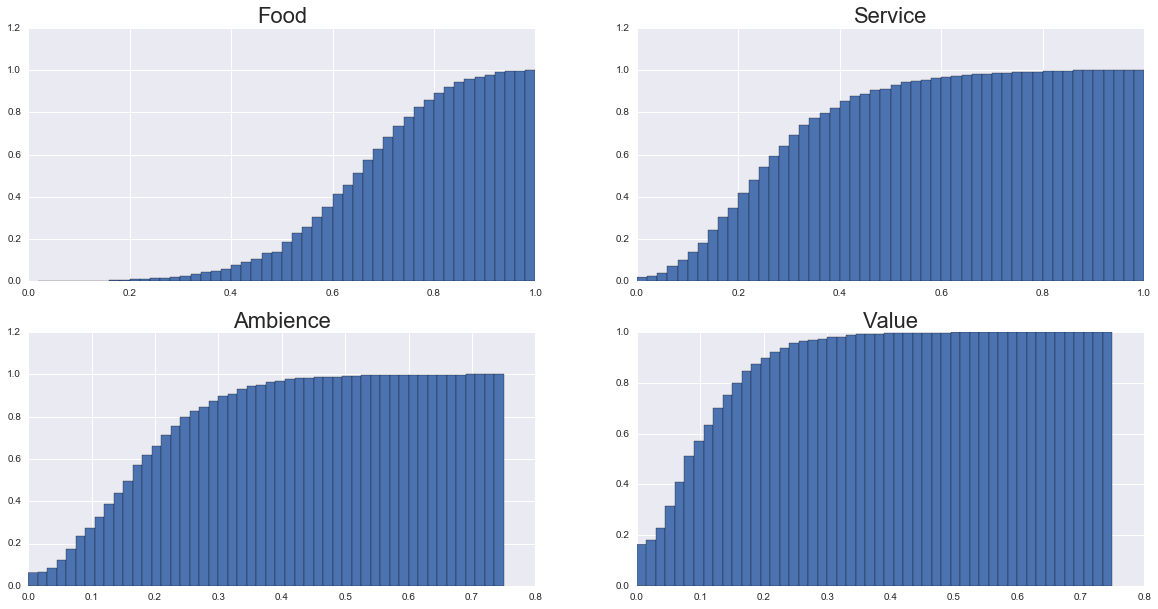

In [7]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.hist(user.pct_food, bins=50, normed=True, cumulative=True)
plt.title("Food", fontsize=22)

plt.subplot(2,2,2)
plt.hist(user.pct_service, bins=50, normed=True, cumulative=True)
plt.title("Service", fontsize=22)

plt.subplot(2,2,3)
plt.hist(user.pct_ambience, bins=50, normed=True, cumulative=True)
plt.title("Ambience", fontsize=22)

plt.subplot(2,2,4)
plt.hist(user.pct_value, bins=50, normed=True, cumulative=True)
plt.title("Value", fontsize=22)

#### Apply PCA for Dimentionality Reduction (for clustering visualization)

In [8]:
reducer = PCA(n_components=2, whiten=True)
reduced = reducer.fit_transform(user[["pct_food","pct_service","pct_ambience","pct_value"]])

reduced = pd.DataFrame(reduced, columns=["PCA_1", "PCA_2"])

print reducer.explained_variance_ratio_
reduced.head(5)

[ 0.6064971   0.23411171]


,PCA_1,PCA_2
0,-0.408727,-0.980165
1,-0.324514,-0.696370
2,-0.312658,-0.043119
3,0.136574,0.789362
4,-1.192974,0.401762


In [9]:
user = pd.concat([user, reduced], axis=1)
user.head(5)

,user_id,topic_food,topic_service,topic_ambience,topic_value,relevant,total,pct_food,pct_service,pct_ambience,pct_value,PCA_1,PCA_2
0,--9jRaeY1xK-2l9r9fVQWA,31,8,13,5,46,90,0.673913,0.173913,0.282609,0.108696,-0.408727,-0.980165
1,--ECBYLVpIfQaeX_35i63Q,48,14,17,17,72,115,0.666667,0.194444,0.236111,0.236111,-0.324514,-0.696370
2,--JM6F4TP_gwzIuw9QSRbA,16,5,4,0,24,31,0.666667,0.208333,0.166667,0.000000,-0.312658,-0.043119
3,--JzqHAkaNejih4O2O9jjw,13,7,3,0,18,23,0.722222,0.388889,0.166667,0.000000,0.136574,0.789362
4,--f43ruUt7LBeB3aU74z-w,23,4,4,0,27,47,0.851852,0.148148,0.148148,0.000000,-1.192974,0.401762


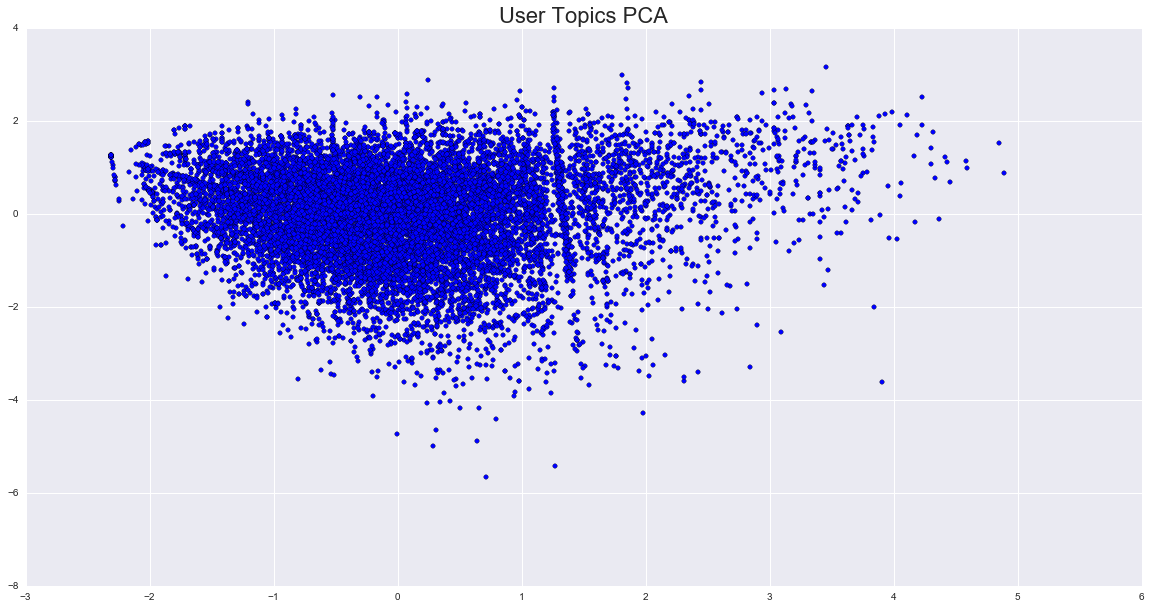

In [10]:
plt.figure(figsize=(20,10))
plt.scatter(user.PCA_1, user.PCA_2)
plt.title("User Topics PCA", fontsize=22)

#### Cluster Yelp Users

#### Create Inertia Curve to Final Optimal K for K-Means

In [11]:
def plot_inertia(df, varlist, max_clusters):
    inertias = []
    for n in range(1 ,max_clusters):
        model = MiniBatchKMeans(n_clusters=n, random_state=4444)
        model.fit(df[varlist])
        
        inertias.append(model.inertia_)
        
    plt.plot(inertias)

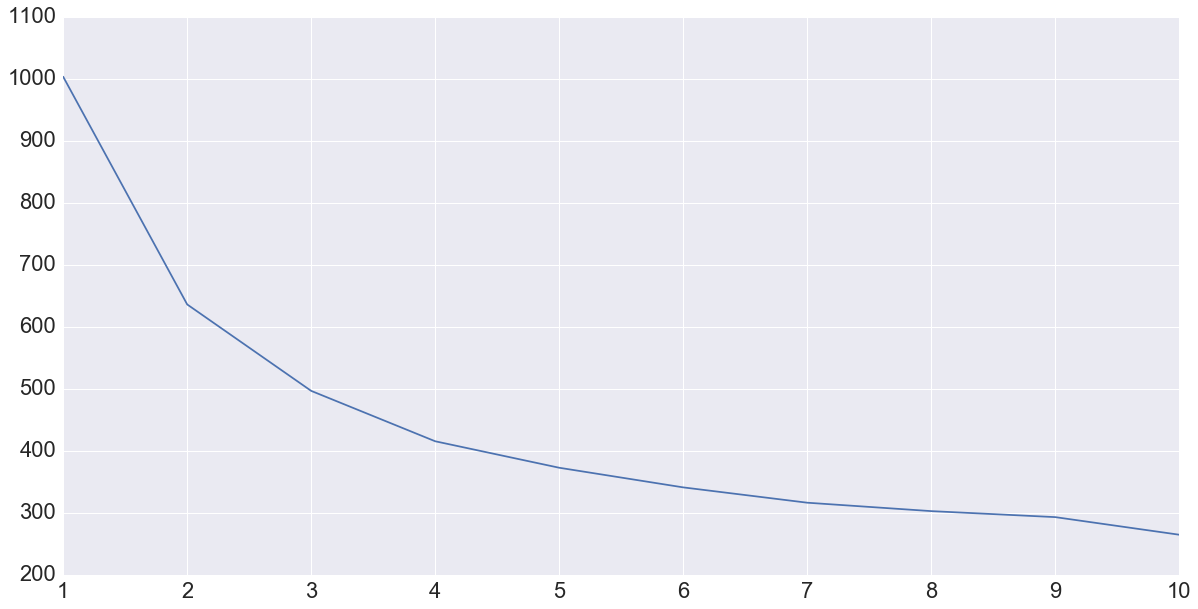

In [12]:
plt.figure(figsize=(20,10))
plot_inertia(user, ["pct_food","pct_service","pct_ambience","pct_value"], max_clusters=11)
plt.xticks([x for x in range(0,10)],[x for x in range(1,11)])
plt.tick_params(labelsize=22)

Optimal number of clusters appears to be K=3 - 5 range

#### K-Means Clustering

In [13]:
def kmeans(df, varlist, n_clusters):
    model = MiniBatchKMeans(n_clusters=n_clusters, random_state=4444)

    clusters = pd.Series(model.fit_predict(df[varlist]), name="cluster")
    clustered = pd.concat([df, clusters], axis=1)
    
    print clustered["cluster"].nunique()
    print clustered["cluster"].value_counts()
    print clustered.groupby(by="cluster")[varlist].mean()
    plt.scatter(clustered.PCA_1, clustered.PCA_2, c=clustered.cluster)
    
    #return clustered

In [14]:
varlist = ["pct_food","pct_service","pct_ambience","pct_value"]

2
0    9385
1    6178
Name: cluster, dtype: int64
         pct_food  pct_service  pct_ambience  pct_value
cluster                                                
0        0.732979     0.185557      0.157817   0.101702
1        0.506381     0.398876      0.200609   0.105524


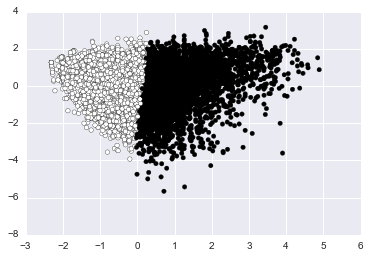

In [15]:
kmeans(user, varlist, n_clusters=2)

3
1    6405
0    6396
2    2762
Name: cluster, dtype: int64
         pct_food  pct_service  pct_ambience  pct_value
cluster                                                
0        0.591251     0.255271      0.244199   0.113144
1        0.775181     0.177809      0.120101   0.095742
2        0.456462     0.519239      0.140957   0.097576


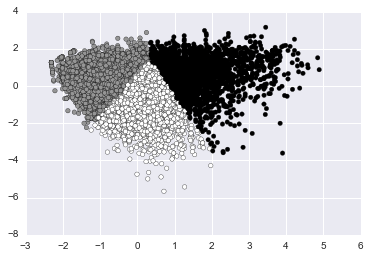

In [16]:
kmeans(user, varlist, n_clusters=3)

4
3    5724
1    4671
0    3520
2    1648
Name: cluster, dtype: int64
         pct_food  pct_service  pct_ambience  pct_value
cluster                                                
0        0.569150     0.216550      0.310050   0.112562
1        0.617186     0.341719      0.136070   0.105455
2        0.389265     0.577332      0.153612   0.096132
3        0.782606     0.156507      0.129342   0.097690


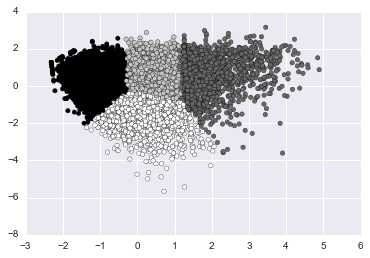

In [17]:
kmeans(user, varlist, n_clusters=4)

5
2    4574
0    4054
4    3700
3    1940
1    1295
Name: cluster, dtype: int64
         pct_food  pct_service  pct_ambience  pct_value
cluster                                                
0        0.640562     0.191986      0.248782   0.117934
1        0.382681     0.611949      0.123417   0.095667
2        0.802097     0.150492      0.114803   0.093349
3        0.470182     0.327771      0.313662   0.104913
4        0.630831     0.354245      0.113099   0.101055


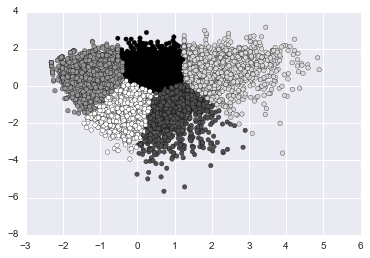

In [18]:
kmeans(user, varlist, n_clusters=5)

6
1    4315
2    3181
3    2760
0    2716
4    1557
5    1034
Name: cluster, dtype: int64
         pct_food  pct_service  pct_ambience  pct_value
cluster                                                
0        0.697840     0.316877      0.095114   0.082790
1        0.666396     0.186370      0.220714   0.118968
2        0.827731     0.127031      0.106519   0.092012
3        0.530354     0.390238      0.168739   0.118637
4        0.494125     0.254262      0.369228   0.100457
5        0.358270     0.642036      0.126029   0.088644


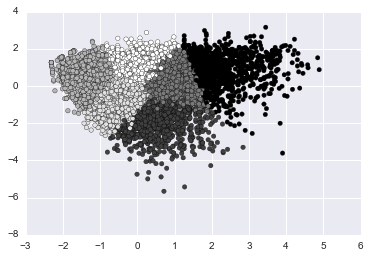

In [19]:
kmeans(user, varlist, n_clusters=6)

#### DBSCAN Clustering

In [22]:
def dbscan(df, varlist, eps, min_samples):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    
    clusters = pd.Series(model.fit_predict(df[varlist]), name="cluster")
    clustered = pd.concat([df, clusters], axis=1)
    
    print clustered["cluster"].nunique()
    print clustered["cluster"].value_counts()
    print clustered.groupby(by="cluster")[varlist].mean()
    plt.scatter(clustered.PCA_1, clustered.PCA_2, c=clustered.cluster)

7
-1    10804
 0     4604
 1       75
 3       26
 2       23
 4       16
 5       15
Name: cluster, dtype: int64
         pct_food  pct_service  pct_ambience  pct_value
cluster                                                
-1       0.620454     0.292078      0.182813   0.112647
 0       0.692076     0.222711      0.157586   0.083827
 1       0.844204     0.075933      0.111025   0.001378
 2       0.765756     0.160983      0.079213   0.000000
 3       0.591971     0.335414      0.151113   0.000894
 4       0.663286     0.143303      0.284376   0.075151
 5       0.719789     0.288895      0.080297   0.139911


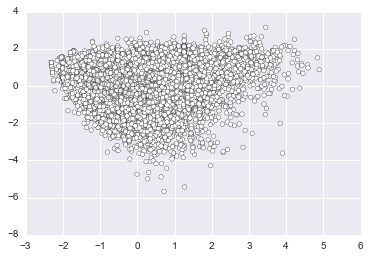

In [23]:
dbscan(user, ["pct_food","pct_service","pct_ambience","pct_value"], eps=0.035, min_samples=25)